In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from scipy.interpolate import CubicSpline


In [2]:
# make arrays suitable for quiver plots
# d, dx set number of quivers
# tti is time index
#x,z,uxarr,uzarr are x,z, ux, uz 4d arrays
# imid is index of y=0
def mkarrs(x,z,uxarr,uzarr,imid,dx,d,tti):
    x2 = np.squeeze(x[::dx,imid,:])
    z2 = np.squeeze(z[::dx,imid,:])
    uu = np.squeeze(uxarr[::dx,imid,:,tti])
    vv = np.squeeze(uzarr[::dx,imid,:,tti])
    #uu_a = np.squeeze(axarr[::dx,imid,:,tti])
    #vv_a = np.squeeze(azarr[::dx,imid,:,tti])
    x_s = np.reshape(x2, (x2.size))
    z_s = np.reshape(z2, (z2.size))
    uu_s = np.reshape(uu, (uu.size))
    vv_s = np.reshape(vv, (vv.size))
    return x_s[::d],z_s[::d],uu_s[::d],vv_s[::d]

In [3]:
R_crater = 1.0
# make xyz cubes
xlin = np.linspace(6,13,50)  # units crater radius. Crater radius defined here.  
ylin = np.linspace(-20,20,50)
zlin = np.linspace(3,7,50)    # note order,  z negative down
x,y,z = np.meshgrid(xlin,ylin,zlin, indexing='ij') # x[i,j,k] 
                            # i varies x, j varies y, k varies z 
# spherical coordinates
r = np.sqrt(x*x + y*y + z*z)
theta = np.arccos(np.abs(z/r))  # is zero on negative z axis
phi = np.arctan2(y,x)
# spherical coords unit vectors 
rhat_x = x/r
rhat_y = y/r
rhat_z = z/r
thetahat_x = np.cos(phi)*np.cos(theta)
thetahat_y = np.sin(phi)*np.cos(theta)
thetahat_z = np.sin(theta)

# time in units of crater radii v_p travel times
dt=0.1    # dt grid spacing
v_p = 1.0  # sets units of time, in crater radii travelled  if R_crater=1
t_r = r/v_p  # vp travel time 
t_z = t_r + np.abs(z)/v_p   # vp travel time + from surface 

# allocate 4d arrays for velocities and accelerations
nt = int(max(xlin)/v_p * 5/dt)  # number of points in time 
# velocities
uxarr = np.zeros([x.shape[0],x.shape[1],x.shape[2],nt])  #4D arrays including time
uyarr = uxarr*0.0
uzarr = uxarr*0.0
# accelerations
axarr = uxarr*0.0
ayarr = uxarr*0.0
azarr = uxarr*0.0

print(nt)  # length of time array

650


Text(0, 0.5, 'a(t) amplitude')

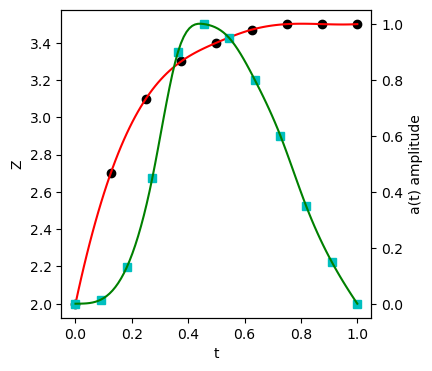

In [4]:
# make up some spline functions
# adjusted so that results look reasonable

tones_fine = np.linspace(0,1,100)
# Z values as a function of time 
zarr = np.array([2.0, 2.7, 3.1, 3.3, 3.4, 3.47, 3.5, 3.5,3.5])
tones = np.linspace(0,1,len(zarr))

spl_z = CubicSpline(tones, zarr)
spl_z_fine = spl_z(tones_fine)
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(tones,zarr,'ko',label='Z')
ax.plot(tones_fine,spl_z_fine,'r-')
#ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('Z')

# amplitude values as a function of time 
#amp = np.array([0,1,0.7,0.4,0.2,0.06,0.0])   # up fast and down slowly
#amp = np.array([0,0.8,0.94,1,0.95,0.8,0.4,0.1,0.0])   # up fast stays high and then drops
amp = np.array([0,0.015,0.13,0.45,0.9,1,0.95,0.8,0.6,0.35,0.15,0.0])  # slow up fast down
tones = np.linspace(0,1,len(amp))
ax2 = ax.twinx()
ax2.plot(tones,amp,'cs',label='a')
spl_a = CubicSpline(tones, amp)
#tones_fine = np.linspace(0,1,50)
spl_a_fine = spl_a(tones_fine)
ax2.plot(tones_fine,spl_a_fine,'g-')
#ax2.legend()
ax2.set_ylabel('a(t) amplitude')

In [5]:
# impact vector
theta_impact = 50.0*np.pi/180.0  # from vertical direction
n_impact = np.array([np.sin(theta_impact), 0 , -np.cos(theta_impact)])
# unit vector 
print(n_impact)

# given two unit vectors compute the angular distance between them
def theta_diff(n1,n2):
    csum=0.0
    for i in range(3):
        csum += n1[i]*n2[i]  # compute dot product
    theta_d = np.arccos(csum)
    return theta_d # angular between two unit vectors

[ 0.76604444  0.         -0.64278761]


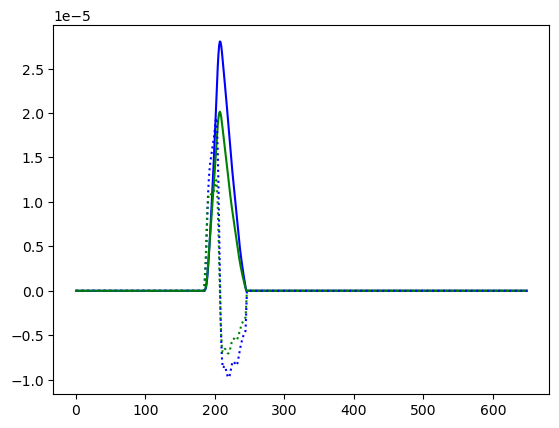

In [6]:

ti_arr = t_r/dt; ti_arr.astype(int)  # indices for arrival times
tj_arr = t_z/dt; tj_arr.astype(int)

# rezero velocity arrays
uxarr = uxarr*0.0 
uyarr = uxarr*0.0
uzarr = uxarr*0.0
epsilon=8  # softening parameter
AA = 0.75  # how much to adjust assymetry

# compute velocity at one point in 3D arrays but as a function of time
# inputs: point depends on i,j,k indexing in 3D 
# depends on globals:
#   epsilon: softening
#   spl_z  : spline function for Z
#   spl_a  : spline function for Amplitude
#   R_crater, vp:   scaling dimensions crater radius and v_p travel speed
#   dt     : sampling for time 
#   r      : 3D array of radii
#   theta  : 3D array spherical coordinate with 0 down -z
#   rhat_x, rhat_y, rhat_z:   3d arrays of radial unit vector
#   thetahat_x, thetahat_y, thetahat_z:  3d arrays of theta unit vector 
#   uxarr,uyarr,uzarr:  velocity arrays 
#   AA: asymmetry parameter
# returns:  nothing but affects uxarr, uyarr, uzarr 
def vfill_oblique(i,j,k):
    ti = int(ti_arr[i,j,k]);   # index for vp arrival time 
    # only start pulse after vp arrival time
    
    #tj = int(tj_arr[i,j,k])  # index for vp+z travel time 

    nma = int(R_crater/v_p *6 /dt)  # width of pulse units array indices
    #print(nma)
    
    # unit vector to current position
    nvec = np.array([rhat_x[i,j,k],rhat_y[i,j,k],rhat_z[i,j,k]])
    theta_d = theta_diff(nvec,n_impact)  
    # angle between current position
    # and impact direction
    
    zto1_a=np.arange(nma)/nma  # goes from 0 to 1, time parameter
    Z_arr = spl_z(zto1_a) # goes from 2 to 3.5 via spline function for Z
    s_arr = spl_a(zto1_a)  # goes from 0 to 1 and down via spline function for amplitude
    s_arr *= 1.0 + AA*np.cos(theta_d)  # adjust amplitude of pulse here!!!!

    # directions and power law set by Maxwell model with time dependent Z and amplitude
    ur_MW = s_arr*(r[i,j,k] + epsilon)**-Z_arr 
    ut_MW = s_arr*(r[i,j,k] + epsilon)**-Z_arr *(Z_arr-2.)\
                     *np.sin(theta[i,j,k])/(1.0 + np.cos(theta[i,j,k]))
    uxarr[i,j,k,ti:ti+nma] = ur_MW*rhat_x[i,j,k]  + ut_MW*thetahat_x[i,j,k]
    uyarr[i,j,k,ti:ti+nma] = ur_MW*rhat_y[i,j,k]  + ut_MW*thetahat_y[i,j,k]
    uzarr[i,j,k,ti:ti+nma] = ur_MW*rhat_z[i,j,k]  + ut_MW*thetahat_z[i,j,k]


# take a look at one profile
i=45;j=40;k=30  
vfill_oblique(i,j,k)
plt.plot(uzarr[i,j,k,:],'b-')
plt.plot(uxarr[i,j,k,:],'g-')
ax = np.gradient(uxarr[i,j,k,:])/dt   # take a look at accelerations too
az = np.gradient(uzarr[i,j,k,:])/dt
plt.plot(az,'b:')
plt.plot(ax,'g:')

In [7]:
# fill the 4D arrays at all positions
for i in range (x.shape[0]):
    for j in range (x.shape[1]):
        for k in range (x.shape[2]):
             vfill_oblique(i,j,k)  
        
    if (i%10 == 0):
        print(i)
        

0
10
20
30
40


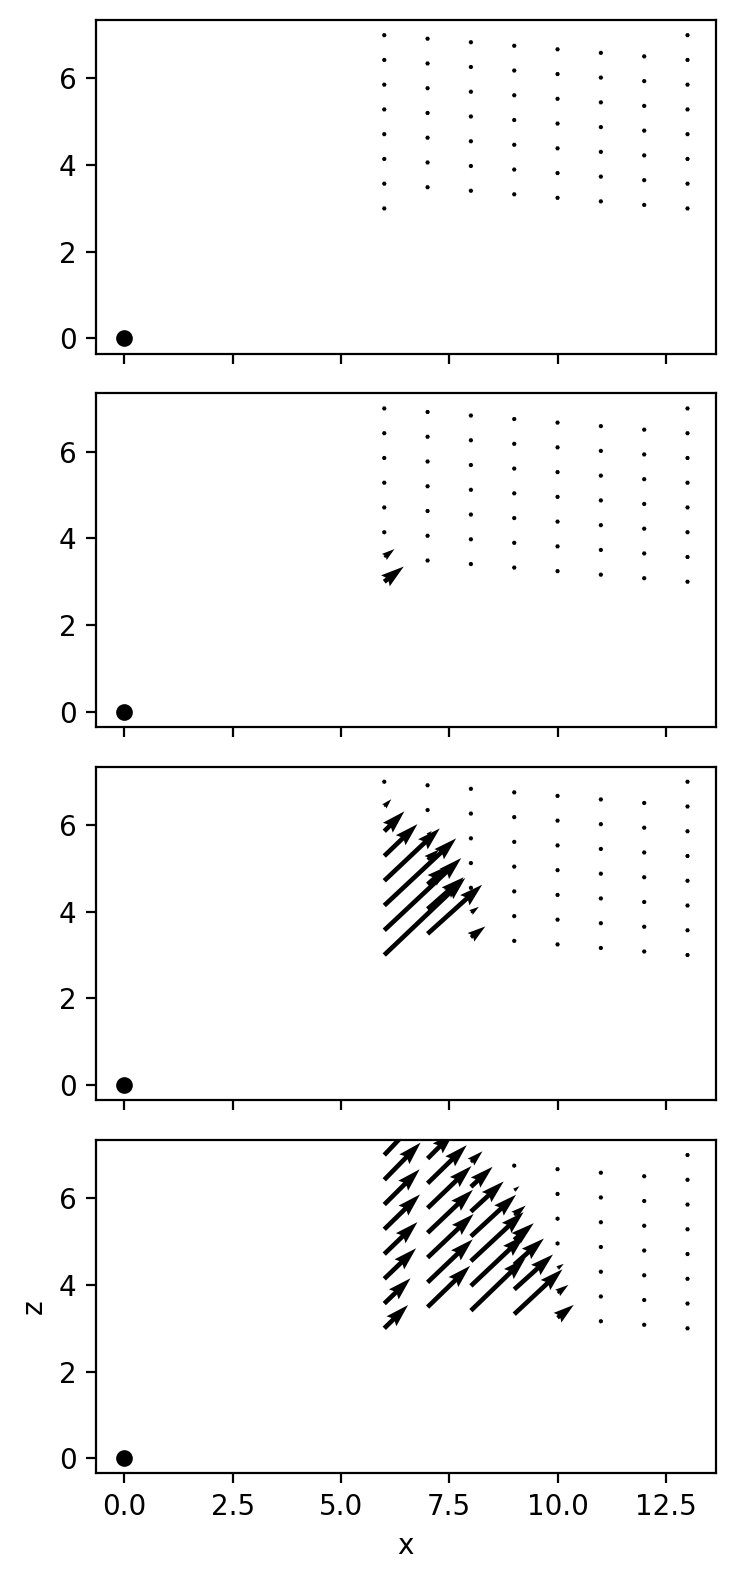

In [8]:
# plot some arrows
imid = np.argmin(np.abs(ylin)) # y midplane index. Midpoint is here?
dx=7; d = 7  # sets spacing of arrows
nw = 4#number of subplots
fig, axarr = plt.subplots(nw,1,figsize=(5,8),sharex=True,sharey=True,dpi=200,\
                         facecolor='white')
plt.subplots_adjust(hspace=0,wspace=0,top=0.80,left=0.1,bottom=0.1,right=0.97)
for i in range(nw):
    axarr[i].set_aspect('equal')#aspect ratio set for each subplot

tti=55  # time index
x_s,z_s,uu_s,vv_s = mkarrs(x,z,uxarr,uzarr,imid,dx,d,tti)  # get 1d arraysx_
q0=axarr[0].quiver(x_s,z_s,uu_s,vv_s,angles='xy', scale_units='xy', scale=1e-4)
#axarr[0].quiverkey(q0,7,-9,0.0005,'a',coordinates='data',labelsep=0.05)
tti=75
x_s,z_s,uu_s,vv_s = mkarrs(x,z,uxarr,uzarr,imid,dx,d,tti)
q1=axarr[1].quiver(x_s,z_s,uu_s,vv_s,angles='xy', scale_units='xy', scale=1e-4)
#axarr[1].quiverkey(q1,7,-9,0.0005,'a',coordinates='data',labelsep=0.05)
tti=95
x_s,z_s,uu_s,vv_s = mkarrs(x,z,uxarr,uzarr,imid,dx,d,tti)
q2=axarr[2].quiver(x_s,z_s,uu_s,vv_s,angles='xy', scale_units='xy', scale=1e-4)
#axarr[2].quiverkey(q2,7,-9,0.0005,'a',coordinates='data',labelsep=0.05)
tti=115
x_s,z_s,uu_s,vv_s = mkarrs(x,z,uxarr,uzarr,imid,dx,d,tti)
q3=axarr[3].quiver(x_s,z_s,uu_s,vv_s,angles='xy', scale_units='xy', scale=1e-4)
#axarr[3].quiverkey(q3,7,-9,0.0005,'a',coordinates='data',labelsep=0.05)
axarr[3].set_ylabel('z')
axarr[3].set_xlabel('x')
plt.tight_layout()

for i in range(nw):
    axarr[i].plot(0,0,'ko',ms=5)
#plt.savefig('oblique_quiver.png')

In [160]:
v=np.zeros((4,13))

for i in range(4):
    #v[i,:]=[-1,-0.7,-0.3,-0.2,-0.1,0,0.1,0.3,0.35,0.4,0.5,0.6,0.7]
    v[i,:]=[0,0,0,0,0,0,-1,-0.4,-0.2,0,0.2,0.3,0.35]

u=np.zeros((4,13))

for i in range(4):
    u[i,:]=[0,0,0,0,0,0,0.54,0.49,0.4,0.35,0.3,0.25,0.2]

v=
u=

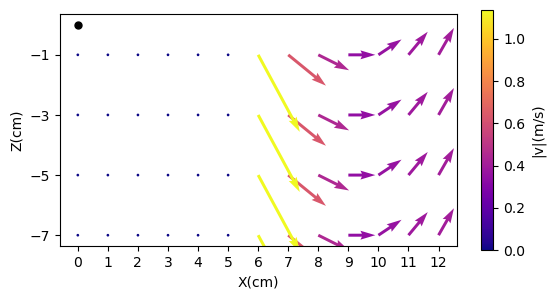

In [165]:
# Creating arrow
y = np.arange(-7, 0, 2)
x = np.arange(0, 13, 1)
 
X, Y = np.meshgrid(x, y)
#v = np.sin(Y)*Y
#u=np.zeros((4,13))
#u=(np.exp(-0.1*X))
#v=np.zeros(np.size(Y))
#v=-(np.exp(-0.1*X))
c = np.sqrt(u**2 + v**2)
# creating plot
fig, ax = plt.subplots()
q=ax.quiver(X, Y, u, v, c,angles='xy', cmap='plasma')
cbar = plt.colorbar(q, label='|v|(m/s)',shrink=0.65)
 
ax.set_aspect('equal')
plt.xticks(x)
plt.yticks(y)
ax.plot(0,0,'ko',ms=5)

plt.xlabel('X(cm)')
plt.ylabel('Z(cm)')

# show plot
plt.show()